In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# v = 0
# m = 1
# angle = 2
# init_altitude = 3
# x = 4
# radius = 5
# y = np.array([velocity,(4*np.pi*radius**3)/3, angle, init_altitude, 0, radius])

def f_solver1(t, y, density):
    Cd = 1
    Ch = 0.1
    Q = 1e7
    Cl = 1e-3
    alpha = 0.3
    Rp = 6371e3
    g = 9.81
    H = 8000
    rho0 = 1.2

    f = np.zeros_like([1, 1, 1, 1, 1, 1],dtype = float)
    # y = np.array([velocity,(4*np.pi*density*radius**3)/3, angle, init_altitude, 0, radius])
    f[0] = g*np.sin(y[2]) + (-Cd * (rho0 * np.exp(-y[3]/H)) *
                             (np.pi * y[5]**2) * y[0]**2) / (2 * y[1])
    f[1] = (-Ch * (rho0 * np.exp(-y[3]/H)) *
            (np.pi * y[5]**2) * y[0]**3) / (2 * Q)
    f[2] = ((g * np.cos(y[2]) / y[0]) - (((Cl * (rho0 * np.exp(-y[3]/H))
                                          * (np.pi * y[5]**2) * y[0])) / (2 * y[1]))
    - ((y[0] * np.cos(y[2]))/(Rp + y[3])))
    f[3] = - y[0] * np.sin(y[2])
    f[4] = y[0] * np.cos(y[2]) / (1 + (y[3] / Rp))
    f[5] = y[0] * np.sqrt(7 * alpha * (rho0 * np.exp(-y[3]/H))/(2 * density))

    return f

In [59]:
def f_solver(t, y, density):
    Cd = 1
    Ch = 0.1
    Q = 1e7
    Cl = 1e-3
    alpha = 0.3
    Rp = 6371e3
    g = 9.81
    H = 8000
    rho0 = 1.2

    f = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    # y = np.array([velocity,(4*np.pi*radius**3)/3, angle, init_altitude, distance, radius])

    f[0] = g*np.sin(y[2]) + (-Cd * (rho0 * np.exp(-y[3]/H))
                             * (np.pi * y[5]**2) * y[0]**2)/(2 * y[1])
    f[1] = (-Ch * (rho0 * np.exp(-y[3]/H)) *
            (np.pi * y[5]**2) * y[0]**3) / (2 * Q)
    f[2] = ((g * np.cos(y[2]) / y[0]) - ((Cl * (rho0 * np.exp(-y[3]/H)) * (np.pi * y[5]**2) * y[0])) / (2 * y[1]) - ((y[0] * np.cos(y[2]))/(Rp + y[3])))
    f[3] = - y[0] * np.sin(y[2])
    f[4] = y[0] * np.cos(y[2]) / (1 + (y[3] / Rp))
    f[5] = 0.0000
#     print((g * np.cos(y[2]) / y[0]) - ((Cl * (rho0 * np.exp(-y[3]/H)) * (np.pi * y[5]**2) * y[0])) / (2 * y[1])- ((y[0] * np.cos(y[2]))/(Rp + y[3])))
    print(f[2])
    return f

In [60]:
def solve_atmospheric_entry(radius, velocity, density, strength, angle, init_altitude=100e3, dt=0.05, radians=False):
    """
    Solve the system of differential equations for a given impact scenario

    Parameters
    ----------
    radius : float
        The radius of the asteroid in meters

    velocity : float
        The entery speed of the asteroid in meters/second

    density : float
        The density of the asteroid in kg/m^3

    strength : float
        The strength of the asteroid (i.e. the maximum pressure it can
        take before fragmenting) in N/m^2

    angle : float
        The initial trajectory angle of the asteroid to the horizontal
        By default, input is in degrees. If 'radians' is set to True, the
        input should be in radians

    init_altitude : float, optional
        Initial altitude in m

    dt : float, optional
        The output timestep, in s

    radians : logical, optional
        Whether angles should be given in degrees or radians. Default=False
        Angles returned in the dataframe will have the same units as the
        input

    Returns
    -------
    Result : DataFrame
        A pandas dataframe containing the solution to the system.
        Includes the following columns:
        'velocity', 'mass', 'angle', 'altitude',
        'distance', 'radius', 'time'
    """
    if radians == False:
            angle = np.radians(angle)
            y = np.array([velocity, (4*np.pi*radius**3)*density /
                          3, angle, init_altitude, 0, radius])
    else:
            y = np.array([velocity, (4*np.pi*radius**3)*density /
                          3, angle, init_altitude, 0, radius])
    t0 = 0
    t = np.array(t0)
    y_all = [y]
    t_all = [t]

    while y[3] > 0:

        if (1.2 * (np.exp(-y[3]/8000)) * y[0]**2) >= strength:
            # print('1')
            k1 = dt * f_solver1(t, y, density)
            k2 = dt * f_solver1(t + 0.5*dt, y + 0.5*k1, density)
            k3 = dt * f_solver1(t + 0.5*dt, y + 0.5*k2, density)
            k4 = dt * f_solver1(t + dt, y + k3, density)
            # print( ((1/6)*(k1 + 2*k2 + 2*k3 + k4))[2])
            y = y + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
            # y =  y + k1
            y_all.append(y)
            t = t + dt
            t_all.append(t)

        else:
            k1 = dt * f_solver(t, y, density)
            k2 = dt * f_solver(t + 0.5*dt, y + 0.5*k1, density)
            k3 = dt * f_solver(t + 0.5*dt, y + 0.5*k2, density)
            k4 = dt * f_solver(t + dt, y + k3, density)
            y = y + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
            # y =  y + k1
            # print( ((1/6)*(k1 + 2*k2 + 2*k3 + k4))[2])    
            y_all.append(y)
            t = t + dt
            t_all.append(t)

    return y_all, t_all

    # Enter your code here to solve the differential equations

    # return pd.DataFrame({'velocity': velocity,
    #                      'mass': np.nan,
    #                      'angle': angle,
    #                      'altitude': init_altitude,
    #                      'distance': 0.0,
    #                      'radius': radius,
    #                      'time': 0.0}, index=range(1))

In [61]:
y_all, t_all = solve_atmospheric_entry(
    radius=35, velocity=19e3, density=3000, strength=1e7, angle=45, init_altitude=100e3, dt=0.05)

-0.001711100425573046
-0.0017113036735958785
-0.001711303676914522
-0.001711506949900161
-0.0017115069498893798
-0.0017117102478314084
-0.0017117102510795987
-0.001711913573966839
-0.0017119135739550654
-0.0017121169217801991
-0.0017121169249518107
-0.0017123202977026761
-0.001712320297689823
-0.0017125236953581195
-0.0017125236984464908
-0.0017127271210189868
-0.0017127271210049594
-0.0017129305684722843
-0.0017129305714701716
-0.0017131340438179287
-0.0017131340438026243
-0.0017133375410202832
-0.001713337543919807
-0.0017135410659917015
-0.0017135410659750085
-0.0017137446128893425
-0.001713744615681934
-0.0017139481874216638
-0.001713948187403461
-0.0017141517839554124
-0.0017141517866317542
-0.0017143554079773848
-0.0017143554079575387
-0.0017145590540821748
-0.0017145590566321318
-0.0017147627275155993
-0.001714762727493967
-0.001714966423119963
-0.001714966425532513
-0.001715170145879086
-0.0017151701458555106
-0.0017153738909045833
-0.0017153738931677408
-0.0017155776628954315


In [62]:
y_all

[array([1.90000000e+04, 5.38783140e+08, 7.85398163e-01, 1.00000000e+05,
        0.00000000e+00, 3.50000000e+01]),
 array([1.90003465e+04, 5.38783109e+08, 7.85312598e-01, 9.93282712e+04,
        6.61439147e+02, 3.50000000e+01]),
 array([1.90006930e+04, 5.38783076e+08, 7.85227013e-01, 9.86565876e+04,
        1.32301563e+03, 3.50000000e+01]),
 array([1.90010394e+04, 5.38783039e+08, 7.85141407e-01, 9.79849493e+04,
        1.98472948e+03, 3.50000000e+01]),
 array([1.90013857e+04, 5.38783000e+08, 7.85055781e-01, 9.73133562e+04,
        2.64658073e+03, 3.50000000e+01]),
 array([1.90017320e+04, 5.38782957e+08, 7.84970134e-01, 9.66418085e+04,
        3.30856942e+03, 3.50000000e+01]),
 array([1.90020782e+04, 5.38782910e+08, 7.84884467e-01, 9.59703061e+04,
        3.97069557e+03, 3.50000000e+01]),
 array([1.90024244e+04, 5.38782859e+08, 7.84798780e-01, 9.52988491e+04,
        4.63295921e+03, 3.50000000e+01]),
 array([1.90027704e+04, 5.38782803e+08, 7.84713072e-01, 9.46274374e+04,
        5.295360

In [16]:
yy = pd.DataFrame(
    y_all, columns=['velocity', 'mass', 'angle', 'altitude', 'distance', 'radius'])

In [17]:
yy

,velocity,mass,angle,altitude,distance,radius
0,19000.000000,5.387831e+08,0.785398,100000.000000,0.000000,35.000000
1,19000.300000,5.387831e+08,0.785398,99328.250000,661.391667,35.000000
2,19000.600000,5.387831e+08,0.785398,98656.500000,1322.841667,35.000000
3,19000.900000,5.387830e+08,0.785398,97984.750000,1984.391667,35.000000
4,19001.200000,5.387830e+08,0.785398,97313.000000,2646.000000,35.000000
...,...,...,...,...,...,...
1529,74.600000,8.777507e+07,0.785398,10.083333,99213.175000,257.841667
1530,74.591667,8.777505e+07,0.785398,7.483333,99215.775000,257.841667
1531,74.566667,8.777502e+07,0.785398,4.883333,99218.375000,257.841667
1532,74.566667,8.777500e+07,0.785398,2.283333,99220.975000,257.841667


In [ ]:
yy['time'] = t_all

In [ ]:
yy = yy.drop(index=345)

In [ ]:
yy

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,5.387831e+08,45.0,100000.000000,0.000000,35.000,0
1,19000.400000,5.387831e+08,45.0,99191.650000,491.350000,35.000,0.05
2,19000.800000,5.387831e+08,45.0,98383.300000,982.791667,35.000,0.1
3,19001.200000,5.387830e+08,45.0,97574.908333,1474.291667,35.000,0.15
4,19001.600000,5.387830e+08,45.0,96766.508333,1965.850000,35.000,0.2
...,...,...,...,...,...,...,...
716,82.841667,8.775342e+07,45.0,10.833333,61244.033333,251.975,35.8
717,82.816667,8.775339e+07,45.0,7.333333,61246.183333,251.975,35.85
718,82.808333,8.775335e+07,45.0,3.833333,61248.333333,251.975,35.9
719,82.783333,8.775332e+07,45.0,0.333333,61250.483333,251.975,35.95


In [ ]:
len(yy.index)

720

In [ ]:
yy

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,5.387831e+08,45.0,100000.000000,0.000000,35.000,0
1,19000.400000,5.387831e+08,45.0,99191.650000,491.350000,35.000,0.05
2,19000.800000,5.387831e+08,45.0,98383.300000,982.791667,35.000,0.1
3,19001.200000,5.387830e+08,45.0,97574.908333,1474.291667,35.000,0.15
4,19001.600000,5.387830e+08,45.0,96766.508333,1965.850000,35.000,0.2
...,...,...,...,...,...,...,...
716,82.841667,8.775342e+07,45.0,10.833333,61244.033333,251.975,35.8
717,82.816667,8.775339e+07,45.0,7.333333,61246.183333,251.975,35.85
718,82.808333,8.775335e+07,45.0,3.833333,61248.333333,251.975,35.9
719,82.783333,8.775332e+07,45.0,0.333333,61250.483333,251.975,35.95


In [ ]:
v = yy.velocity
m = yy.mass
a = yy.altitude
v0 = 19000
dedz = m * (v**2)/(2*a)/1000000

In [ ]:
dedz

0      9.725036e+05
1      9.885675e+05
2      1.005169e+06
3      1.022335e+06
4      1.040096e+06
           ...     
340    1.003852e+04
341    1.304270e+04
342    1.860437e+04
343    3.249368e+04
344    1.292315e+05
Length: 345, dtype: float64

In [ ]:
yy['dedz'] = dedz

In [ ]:
yy

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19000.000000,5.387831e+08,45.0,100000.000000,0.000000,35.000000,0,9.725036e+05
1,19000.800000,5.387831e+08,45.0,98383.300000,982.783333,35.000000,0.1,9.885675e+05
2,19001.600000,5.387830e+08,45.0,96766.516667,1965.866667,35.000000,0.2,1.005169e+06
3,19002.400000,5.387829e+08,45.0,95149.700000,2949.250000,35.000000,0.3,1.022335e+06
4,19003.200000,5.387828e+08,45.0,93532.800000,3932.866667,35.000000,0.4,1.040096e+06
...,...,...,...,...,...,...,...,...
340,83.333333,8.774471e+07,45.0,30.350000,61232.150000,250.716667,34.0,1.003852e+04
341,83.316667,8.774464e+07,45.0,23.350000,61236.450000,250.716667,34.1,1.304270e+04
342,83.266667,8.774457e+07,45.0,16.350000,61240.750000,250.716667,34.2,1.860437e+04
343,83.216667,8.774450e+07,45.0,9.350000,61245.050000,250.716667,34.3,3.249368e+04


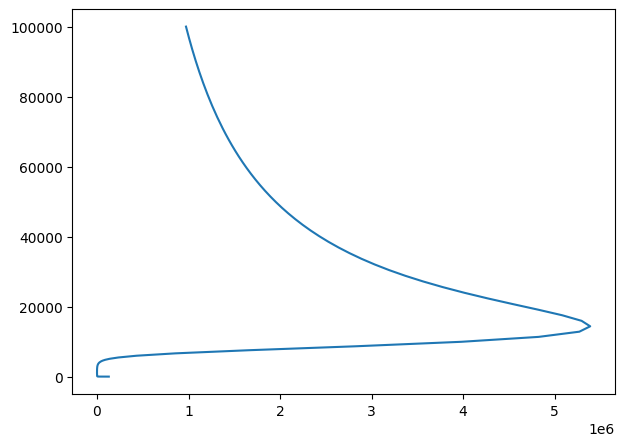

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.plot(dedz,a)

In [1]:
from solver import Planet

In [2]:
xx = Planet().solve_atmospheric_entry(radius=35, velocity=19e3, density=3000, strength=1e7, angle=45, init_altitude=100e3, dt=0.05, radians=False)

In [3]:
yy = Planet().calculate_energy(xx)

In [4]:
yy

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19000.000000,5.387831e+08,45.000000,100000.000000,0.000000,35.000000,0,972503.567864
1,19000.346821,5.387831e+08,44.995097,99328.271166,661.439152,35.000000,0.05,979116.076846
2,19000.693612,5.387831e+08,44.990194,98656.587563,1323.015650,35.000000,0.1,985818.177426
3,19001.040374,5.387831e+08,44.985289,97984.949213,1984.729528,35.000000,0.15,992611.702546
4,19001.387106,5.387831e+08,44.980383,97313.356137,2646.580821,35.000000,0.2,999498.535487
...,...,...,...,...,...,...,...,...
1200,85.832584,8.775379e+07,89.500786,21.676727,96771.357171,251.062039,60.0,14912.365046
1201,85.814929,8.775375e+07,89.503292,17.385702,96771.394465,251.062039,60.05,18585.281912
1202,85.797289,8.775371e+07,89.505785,13.095557,96771.431565,251.062039,60.1,24663.724060
1203,85.779662,8.775367e+07,89.508263,8.806292,96771.468471,251.062039,60.15,36661.556383


In [5]:
Planet().analyse_outcome(yy)

{'outcome': 'Airburst',
 'burst_altitude': 16484.513920745074,
 'burst_distance': 83660.27945109812,
 'burst_peak_dedz': 5024246.840107238}

In [32]:
# table = pd.read_csv('~/acs-armageddon-Dimorphos/resources/AltitudeDensityTable.csv')

In [31]:
# def create_tabular_density(self, filename="./resources/AltitudeDensityTable.csv"):
#         """
#         Create a function given altitude return the density of atomosphere
#         using tabulated value
#         Parameters
#         ----------
#         filename : str, optional
#             Path to the tabular. default="./resources/AltitudeDensityTable.csv"
#         Returns
#         -------
#         tabular_density : function
#             A function that takes altitude as input and return the density of
#             atomosphere density at given altitude.
#         """
#         X = []
#         Y = []
#         data = pd.read_csv(filename)
#         for i in data[data.keys()[0]]:
#             temp = i.split()
#             X.append(eval(temp[0]))
#             Y.append(eval(temp[1]))
#         def tabular_density(x):
#             if x > X[-1]:
#                 return 0
#             for i in range(len(X)):
#                 if X[i] >= x:
#                     break
#             pressure = (x - X[i-1])/(X[i] - X[i-1]) * (Y[i] - Y[i-1]) + Y[i-1]

#             return pressure
#         return tabular_density

,# Altitude (m) Atmospheric Density (kg/m3)
0,0.0000000000000000e+00 1.2250000000000001e+00
1,2.0000000000000000e+03 1.0064900000000001e+00
2,4.0000000000000000e+03 8.1912900000000000e-01
3,6.0000000000000000e+03 6.5969699999999998e-01
4,8.0000000000000000e+03 5.2516799999999997e-01
5,1.0000000000000000e+04 4.1270699999999999e-01
6,1.2000000000000000e+04 3.1082799999999999e-01
7,1.4000000000000000e+04 2.2675300000000001e-01
8,1.6000000000000000e+04 1.6542000000000001e-01
9,1.8000000000000000e+04 1.2067600000000001e-01


In [27]:
# table.columns

Index(['# Altitude (m)          Atmospheric Density (kg/m3)'], dtype='object')

In [10]:
# table[table.Altitude.values ==  ]

,# Altitude (m) Atmospheric Density (kg/m3)
0,0.0000000000000000e+00 1.2250000000000001e+00
1,2.0000000000000000e+03 1.0064900000000001e+00
2,4.0000000000000000e+03 8.1912900000000000e-01
3,6.0000000000000000e+03 6.5969699999999998e-01
4,8.0000000000000000e+03 5.2516799999999997e-01
5,1.0000000000000000e+04 4.1270699999999999e-01
6,1.2000000000000000e+04 3.1082799999999999e-01
7,1.4000000000000000e+04 2.2675300000000001e-01
8,1.6000000000000000e+04 1.6542000000000001e-01
9,1.8000000000000000e+04 1.2067600000000001e-01
